Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# !pip install tensorflow-gpu

In [3]:
#!nvidia-smi

## Data Reading/Data Understanding



#### Importing all the important libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten,Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential

from glob import glob

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

train_path = '/content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train'
test_path = '/content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Test'

data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
folders = glob('/content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/*')
folders

['/content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/seborrheic keratosis',
 '/content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/actinic keratosis',
 '/content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/squamous cell carcinoma',
 '/content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/basal cell carcinoma',
 '/content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/nevus',
 '/content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/dermatofibroma',
 '/content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/melanoma',
 '/content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/vascular lesion',
 '/content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/pigmented benign keratosis']

In [7]:
image_count_train = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

118
118


## Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180    

In [9]:
data = tf.keras.utils.image_dataset_from_directory( data_dir_train,
  labels = "inferred",
  #label_mode = "categorical",
  color_mode = "rgb",
  batch_size = batch_size,
  image_size = (img_height,img_width),
  seed = 123
)

Found 2239 files belonging to 9 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

Use 80% of the images for training, and 20% for validation.

In [12]:
#Split Data
train_size = int(len(data)*.8)
val_size = int(len(data)*.2)


train_ds = data.take(train_size)
val_ds = data.skip(train_size).take(val_size)


In [13]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = data.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


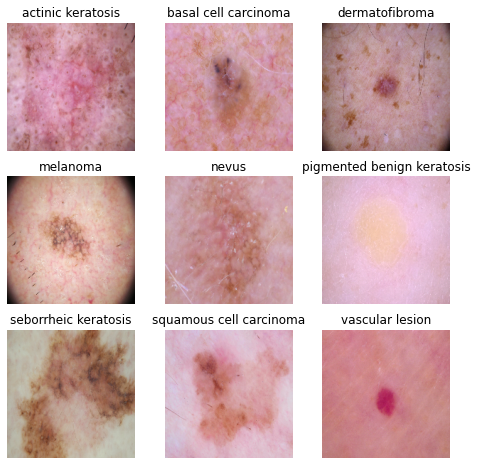

In [33]:
fig = plt.figure(figsize=(8,8))

for i in range(len(class_names)):
    filtered_ds = data.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = fig.add_subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')


In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
### Your code goes here
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.11143763 0.9462417


In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [19]:
### Todo, choose an appropirate optimiser and loss function


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 17s 258ms/step - loss: 2.1497 - accuracy: 0.2009 - val_loss: 2.0460 - val_accuracy: 0.2483
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 1.8840 - accuracy: 0.3086 - val_loss: 1.8573 - val_accuracy: 0.3110
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.6228 - accuracy: 0.4102 - val_loss: 1.6051 - val_accuracy: 0.4787
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4609 - accuracy: 0.4860 - val_loss: 1.6407 - val_accuracy: 0.4631
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3519 - accuracy: 0.5368 - val_loss: 1.4332 - val_accuracy: 0.4989
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2188 - accuracy: 0.5720 - val_loss: 1.7883 - val_accuracy: 0.4720
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1513 - accuracy: 0.5988 - val_loss: 1.4670 - val_accuracy: 0.5034
Epoch 8/20


### Visualizing training results

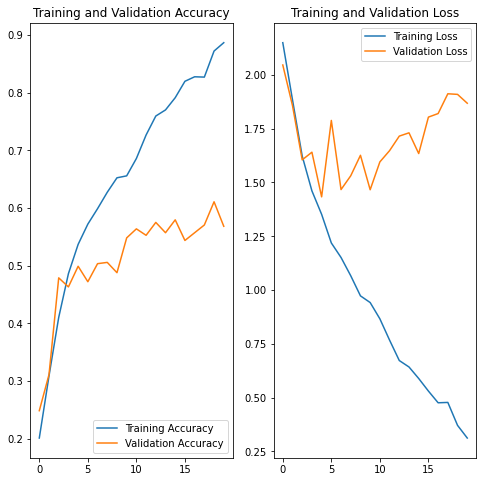

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Findings:

The plots show that training accuracy is around 88% and validation accuracy is 
around 57%. Both are are off by large margins. 
The difference in accuracy between training and validation accuracy is noticeable which a sign of overfitting

In [23]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

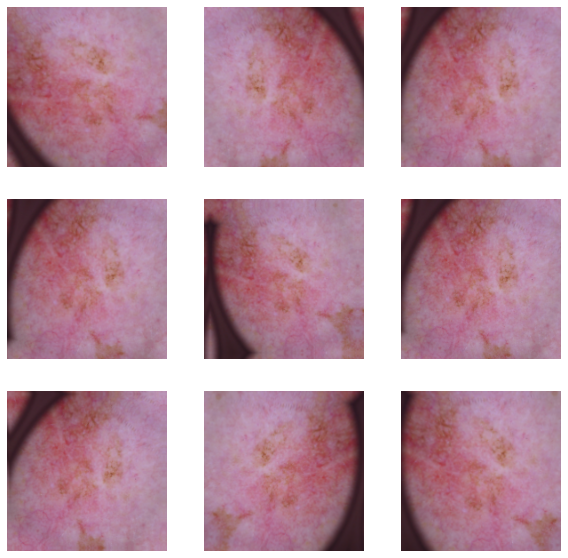

In [24]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [26]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [28]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 30ms/step - loss: 2.1088 - accuracy: 0.2617 - val_loss: 1.8344 - val_accuracy: 0.3826
Epoch 2/20
56/56 [==============================] - 1s 26ms/step - loss: 1.7265 - accuracy: 0.3610 - val_loss: 1.6522 - val_accuracy: 0.4161
Epoch 3/20
56/56 [==============================] - 1s 26ms/step - loss: 1.5831 - accuracy: 0.4408 - val_loss: 1.5743 - val_accuracy: 0.4385
Epoch 4/20
56/56 [==============================] - 1s 27ms/step - loss: 1.5215 - accuracy: 0.4565 - val_loss: 1.5690 - val_accuracy: 0.4676
Epoch 5/20
56/56 [==============================] - 2s 27ms/step - loss: 1.3925 - accuracy: 0.5145 - val_loss: 1.3980 - val_accuracy: 0.4966
Epoch 6/20
56/56 [==============================] - 1s 26ms/step - loss: 1.3482 - accuracy: 0.5234 - val_loss: 1.4317 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 1s 27ms/step - loss: 1.3367 - accuracy: 0.5329 - val_loss: 1.4786 - val_accuracy: 0.4765
Epoch 8/20
56

### Visualizing the results

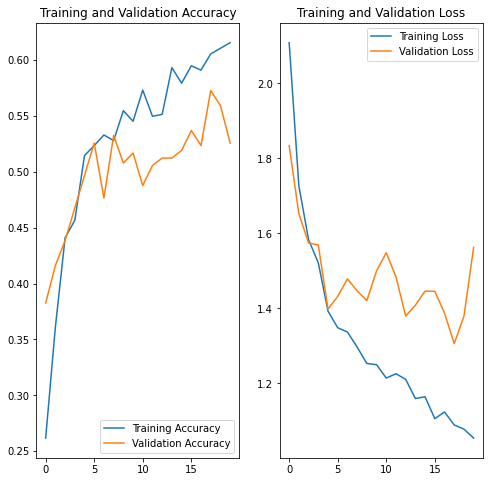

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?


**Here we can see less overfitting than before, and training and validation accuracy are closer than before. Using Dropout layer has improved the model compared to previous one.**

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [30]:
## Your code goes here.

num_classes = len(class_names)

count = np.zeros(num_classes, dtype=np.int32)
for images, labels in data:
    y, _, c = tf.unique_with_counts(labels)
    count[y.numpy()] += c.numpy()

sanity_check = dict(zip(class_names,count))
print(sanity_check)


{'actinic keratosis': 114, 'basal cell carcinoma': 376, 'dermatofibroma': 95, 'melanoma': 438, 'nevus': 357, 'pigmented benign keratosis': 462, 'seborrheic keratosis': 77, 'squamous cell carcinoma': 181, 'vascular lesion': 139}


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? => **'seborrheic keratosis'**
#### - Which classes dominate the data in terms proportionate number of samples? => **'pigmented benign keratosis'**


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
path_to_training_dataset= '/content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7FF6050750>: 100%|██████████| 500/500 [00:17<00:00, 27.84 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7FF63CE190>: 100%|██████████| 500/500 [00:17<00:00, 28.41 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7FF6373750>: 100%|██████████| 500/500 [00:20<00:00, 24.70 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2597x2185 at 0x7F7FF60619D0>: 100%|██████████| 500/500 [01:23<00:00,  6.00 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=962x674 at 0x7F7FF5FB9490>: 100%|██████████| 500/500 [01:29<00:00,  5.58 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7FF602C610>: 100%|██████████| 500/500 [00:18<00:00, 27.06 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8088841C90>: 100%|██████████| 500/500 [00:41<00:00, 11.98 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7FF633BAD0>: 100%|██████████| 500/500 [00:18<00:00, 26.37 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7FF602A3D0>: 100%|██████████| 500/500 [00:18<00:00, 27.37 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

### Lets see the distribution of augmented data after adding new images to the original training data.

In [50]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011138.jpg_3136f9cb-0c96-4114-8238-1d7b9bd2e55b.jpg',
 '/content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010878.jpg_95e36481-a8b9-473e-ad9c-43fce34f438b.jpg',
 '/content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010965.jpg_f8d92b7a-47e0-4ce8-809b-c05b894631f0.jpg',
 '/content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011032.jpg_83574975-0723-4821-b4d6-a6f5f2fd934b.jpg',
 '/content/gdrive/MyDrive/Learning/Melanoma Detection Assignment/Dataset/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010912.jpg_cdddee4d-0bae-40b0-b14a-6aaaddb16d32.jpg',
 '/content/gdri

In [51]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [52]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [54]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2


In [55]:
new_df['Label'].value_counts()

seborrheic keratosis          500
actinic keratosis             500
squamous cell carcinoma       500
basal cell carcinoma          500
nevus                         500
dermatofibroma                500
melanoma                      500
vascular lesion               500
pigmented benign keratosis    500
Name: Label, dtype: int64

#### **Todo**: Train the model on the data created using Augmentor

In [56]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [62]:
data_dir_train= train_path #"path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [63]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset =  "validation", # Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [64]:
## your code goes here
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.13889101 0.9218937


In [66]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [67]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

#### **Todo:**  Train your model

In [68]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 32s 181ms/step - loss: 1.8592 - accuracy: 0.2927 - val_loss: 1.4777 - val_accuracy: 0.4343
Epoch 2/30
169/169 [==============================] - 31s 177ms/step - loss: 1.4484 - accuracy: 0.4490 - val_loss: 1.3503 - val_accuracy: 0.4774
Epoch 3/30
169/169 [==============================] - 30s 172ms/step - loss: 1.3416 - accuracy: 0.4881 - val_loss: 1.3131 - val_accuracy: 0.5145
Epoch 4/30
169/169 [==============================] - 31s 180ms/step - loss: 1.2632 - accuracy: 0.5174 - val_loss: 1.2357 - val_accuracy: 0.5271
Epoch 5/30
169/169 [==============================] - 30s 172ms/step - loss: 1.2274 - accuracy: 0.5349 - val_loss: 1.2221 - val_accuracy: 0.5145
Epoch 6/30
169/169 [==============================] - 30s 174ms/step - loss: 1.1476 - accuracy: 0.5636 - val_loss: 1.2140 - val_accuracy: 0.5494
Epoch 7/30
169/169 [==============================] - 30s 172ms/step - loss: 1.1204 - accuracy: 0.5727 - val_loss: 1.1207 - val_ac

#### **Todo:**  Visualize the model results

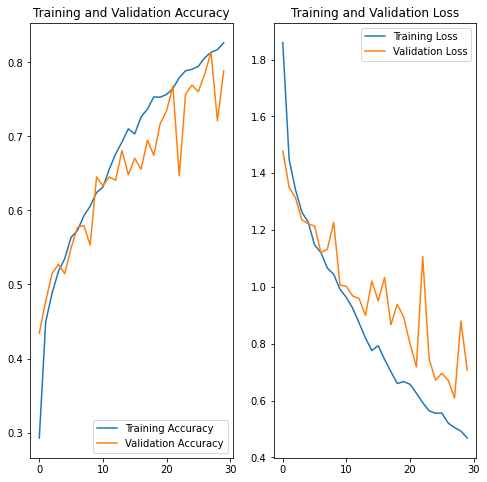

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



We have got rid off overfitting. Class rebalance has improved the model